In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

import numpy as np
import pandas as pd
import fdsreader

from IPython.display import display
from PIL import Image

# Data Analysis II

This example demonstrates an analysis of slice data, here to determine the map of available safe egress time (ASET) and the temporal evolution of the smoke layer height. The used scenario is a multi-room appartment.

:::{figure-md} fig-example-dataanalysis2-scenario-geometry

<img src="figs/appartment_geometry.png" width="100%">

Visualization of the appartment geometry.
:::

````{admonition} Full FDS input file
:class: tip, dropdown
```{literalinclude} data/compartment/appartment_01/appartment.fds
```
````

````{admonition} Precomputed simulation data
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=compartment_appartment_01.zip)
````

As shown in [the introduction to fdsreader](../../tools/03_analysis/02_fdsreaders), the FDS simulation results can be read as Python data structures. The simulation consists out of eight meshes. 

In [2]:
path_to_data = 'data/compartment/appartment_01/rundir'

sim = fdsreader.Simulation(path_to_data)
print(sim)

Simulation(chid=Appartment,
           meshes=8,
           obstructions=23,
           slices=20,
           smoke_3d=3)


## ASET Map

This section demonstrate how to compute ASET maps based on the procedure described in {cite}`Schroeder.2020`. The basic idea is to determine for each position in the compartment the first time that a tenability criterion is exceeded. The result is a time map.

Although the procedure is based on multiple criteria, for simlicity only one quantity, here the soot density, is used. Its values are evaluated in a z-normal slice at an arbitrary height of $\SI{1.5}{\meter}$.

In [48]:
# get the soot density slice, normal to z at 1.5m height
slc = sim.slices.get_by_id('SootDensityZ_1.5m')

# as the simulation is based on multiple meshes, a global 
# data structure is created, walls are represented as
# non-valid data points, i.e. nan
slc_data = slc.to_global(masked=True, fill=np.nan)


First, a visualisation of the data at a selected point is done with the `imshow` function.

In [49]:
# find the time index
it = slc.get_nearest_timestep(50)

# visualise the data
plt.imshow(slc_data[it,:,:].T, origin='lower', extent=slc.extent.as_list())

# add labels
plt.title(f'Soot Density at t={slc.times[it]:.2f}s')
plt.xlabel('position / m')
plt.ylabel('position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' )

# save output to file
plt.savefig('figs/appartment_soot_z.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-soot_z

<img src="figs/appartment_soot_z.svg" width="100%">

Visualization of the soot density.
:::

Now, the local ASET values are computed:
1. Iterate over all spatial elements of the slice
1. Determine all points in time which exceed the tenability threshold
1. If this happens at any time, set the first time to be the local ASET value

In [50]:
# set arbitrary values as tenability threshold
soot_density_limit = 1e-4

# create a map with max ASET as default value
aset_map = np.full_like(slc_data[0], slc.times[-1])

# set walls to nan
aset_map[np.isnan(slc_data[0,:,:])] = np.nan

# 1D loop over all array indices, ix is a two dimensional index
for ix in np.ndindex(aset_map.shape):
    
    # find spatialy local values which exceed the given limit 
    local_aset = np.where(slc_data[:, ix[0], ix[1]] > soot_density_limit)[0]
    
    # if any value exists
    if len(local_aset) > 0:
        # use the first, i.e. first in time, as the local ASET value
        aset_map[ix] = slc.times[local_aset[0]]


With the computed map, a graphical respresentation of the ASET map is done the same way as with the other quantities. Here, a discrete color map is used.

In [51]:
# create a discrete (12 values) color map
cmap = matplotlib.cm.get_cmap('jet_r', 12)

# visualise the data
plt.imshow(aset_map.T, origin='lower', extent=slc.extent.as_list(), cmap=cmap)
plt.title(f'ASET Map with Soot Density Limit of {soot_density_limit:.1e}')
plt.xlabel('x position / m')
plt.ylabel('y position / m')
plt.colorbar(orientation='horizontal', label='time / s' );

# save output to file
plt.savefig('figs/appartment_aset_map.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-aset-map

<img src="figs/appartment_aset_map.svg" width="100%">

ASET map for the outlined scenario.
:::

## Smoke layer

In [8]:
slc = sim.slices.get_by_id('BurnerTempX')
slc_data = slc.to_global(masked=True, fill=np.nan)
slc_coords = slc.get_coordinates()

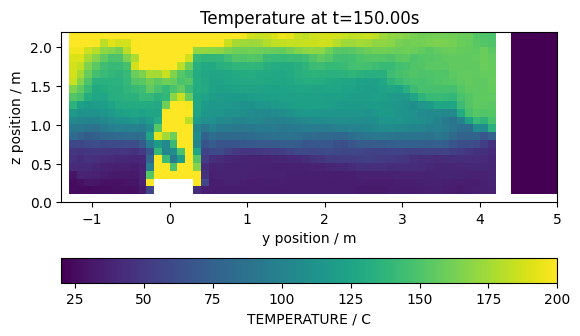

In [20]:
it = slc.get_nearest_timestep(150)
plt.imshow(slc_data[it,:,:].T, origin='lower', vmax=200, extent=slc.extent.as_list())
plt.title(f'Temperature at t={slc.times[it]:.2f}s')
plt.xlabel('y position / m')
plt.ylabel('z position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' );

In [21]:
temperature_limit = 100

res = np.full(slc_data.shape[1], slc_coords['z'][-1])

for ix in np.ndindex(res.shape):
    lt = np.where(slc_data[it, ix, :] > temperature_limit)[1]
    if len(lt) > 0:
        res[ix] = slc_coords['z'][lt[0]]

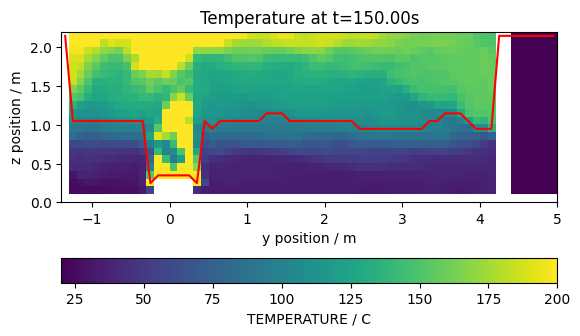

In [22]:
plt.imshow(slc_data[it,:,:].T, origin='lower', vmax=200, extent=slc.extent.as_list())
plt.title(f'Temperature at t={slc.times[it]:.2f}s')
plt.xlabel('y position / m')
plt.ylabel('z position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' );
plt.plot(slc_coords['y'], res, color='red')

In [23]:
temperature_limit = 100
layer_mean = np.zeros_like(slc.times)
layer_stddev = np.zeros_like(slc.times)

for it in range(len(slc.times)):

    res = np.full(slc_data.shape[1], slc_coords['z'][-1])

    for ix in np.ndindex(res.shape):
        lt = np.where(slc_data[it, ix, :] > temperature_limit)[1]
        if len(lt) > 0:
            res[ix] = slc_coords['z'][lt[0]]
            
    layer_mean[it] = np.mean(res)
    layer_stddev[it] = np.std(res)

Text(0, 0.5, 'Height / m')

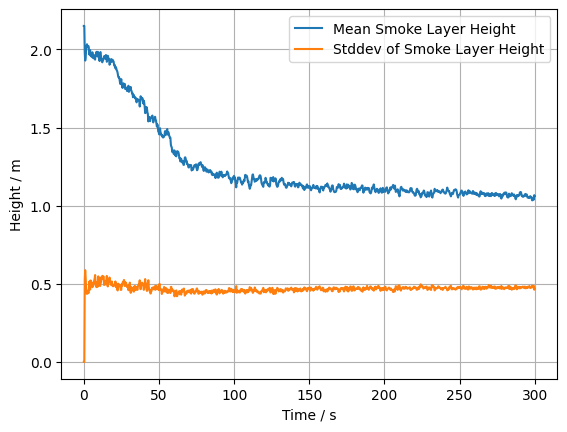

In [28]:
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')
plt.plot(slc.times, layer_stddev, label='Stddev of Smoke Layer Height')
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')

Text(0, 0.5, 'Height / m')

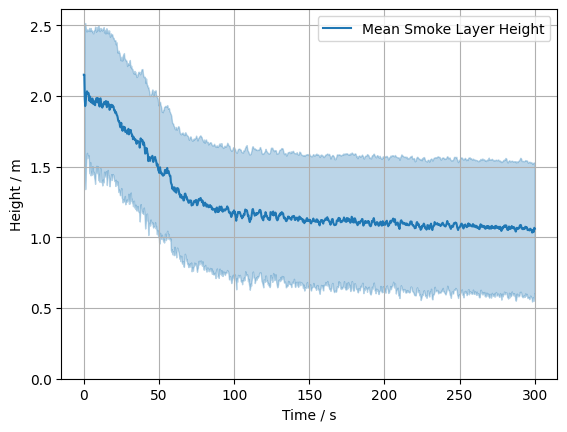

In [32]:
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')
plt.fill_between(slc.times, layer_mean-layer_stddev, layer_mean+layer_stddev, color='C0', alpha=0.3)
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')

In [36]:
temperature_limit = 100
layer_mean = np.zeros_like(slc.times)
layer_stddev = np.zeros_like(slc.times)
ymin = 1
ymax = 4
mask = np.where((slc_coords['y'] > ymin) & (slc_coords['y'] < ymax))

for it in range(len(slc.times)):

    res = np.full(slc_data.shape[1], slc_coords['z'][-1])

    for ix in np.ndindex(res.shape):
        lt = np.where(slc_data[it, ix, :] > temperature_limit)[1]
        if len(lt) > 0:
            res[ix] = slc_coords['z'][lt[0]]
            
    layer_mean[it] = np.mean(res[mask])
    layer_stddev[it] = np.std(res[mask])

Text(0, 0.5, 'Height / m')

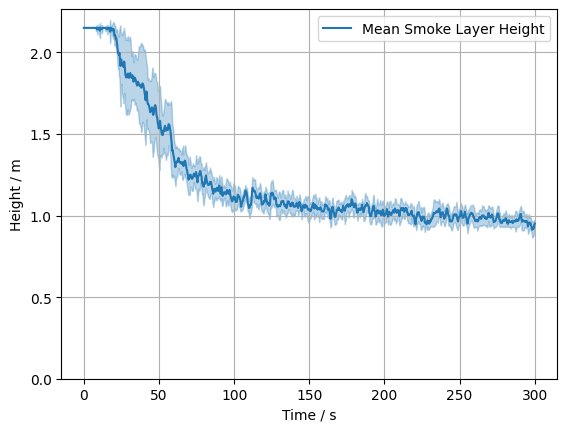

In [37]:
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')
plt.fill_between(slc.times, layer_mean-layer_stddev, layer_mean+layer_stddev, color='C0', alpha=0.3)
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')